In [1]:
# Setup imports and paths
import os, sys, glob, pprint
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Ensure project root is on sys.path so we can import local modules
PROJECT_ROOT = os.path.abspath('.')
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import analysis as analysis_module  # helper script
from setup import RoombaSoftPOMDPEnv

print('Project root:', PROJECT_ROOT)

Project root: c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba


In [2]:
# Analysis: specify a single map .npy and a single CSV file to analyze
map_dir = os.path.join(PROJECT_ROOT, 'test_scenarios')
# Edit these two variables to choose which map and CSV to analyze
# MAP_NAME = 'single_soft_center'
MAP_NAME = 'mixed_obstacles_seed42'
# MAP_NAME = 'scattered_soft_seed123'
method = 'sarsa'
MAP_PATH = os.path.join(map_dir, f'{MAP_NAME}_map.npy')
CSV_PATH = os.path.join(PROJECT_ROOT, 'scenario_results', f'{MAP_NAME}', method)
CSV_PATH = os.path.join(CSV_PATH, os.listdir(CSV_PATH)[0])
print('MAP_NAME=', MAP_NAME)
print('MAP_PATH exists=', os.path.exists(MAP_PATH), 'CSV_PATH exists=', os.path.exists(CSV_PATH))

MAP_NAME= mixed_obstacles_seed42
MAP_PATH exists= True CSV_PATH exists= True


In [3]:
# Single-file mode: show selection
print('Selected map:', MAP_NAME)
print('Map file:', MAP_PATH)
print('CSV file:', CSV_PATH)

Selected map: mixed_obstacles_seed42
Map file: c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\test_scenarios\mixed_obstacles_seed42_map.npy
CSV file: c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\scenario_results\mixed_obstacles_seed42\sarsa\2025-12-05-17-05-22.csv


In [4]:
# Run the analysis for the selected map+csv and display outputs inline.
OUTDIR = os.path.join(PROJECT_ROOT, 'analysis_out_notebook')
os.makedirs(OUTDIR, exist_ok=True)
summary_rows = []
# Single-file mode: use MAP_NAME, MAP_PATH, CSV_PATH
map_key = MAP_NAME
map_path = MAP_PATH
csvp = CSV_PATH
episode_nr = 499
print('===>', map_key, '===')
if not os.path.exists(map_path):
    print('Map file not found:', map_path)
elif csvp is None or not os.path.exists(csvp):
    print('CSV file not found for', map_key, '(', csvp, ') -- skipping')
else:
    print('Using CSV:', csvp)
    map_arr = np.load(map_path)
    H, W = map_arr.shape
    env = RoombaSoftPOMDPEnv(width=W, height=H, map_array=map_arr, random_obstacles=False)
    name = os.path.splitext(os.path.basename(csvp))[0]
    out_sub = os.path.join(OUTDIR, map_key + '__' + name)
    os.makedirs(out_sub, exist_ok=True)
    rows = analysis_module.read_csv(csvp)
    episodes = analysis_module.group_by_episode(rows)
    per_ep = []
    for i, ep_rows in enumerate(episodes):
        metrics = analysis_module.compute_metrics_for_episode(ep_rows, env=env)
        per_ep.append(metrics)
        heatpath = os.path.join(out_sub, f'ep_{i:02d}_heat.png')
        # analysis_module.render_heatmap(env, metrics['heatmap'], outpath=heatpath, title=f'{name} ep {i} heatmap')
    dfrows = []
    for i, m in enumerate(per_ep):
        dfrows.append({'episode': i, 'total_reward': m['total_reward'], 'coverage': m['coverage'], 'entropy': m['entropy']})
    df = pd.DataFrame(dfrows)
    csv_out = os.path.join(out_sub, 'summary_per_episode.csv')
    df.to_csv(csv_out, index=False)
    print('Wrote', csv_out)
    last_heat = os.path.join(out_sub, f'ep_{len(per_ep)-1:02d}_heat.png')
    if os.path.exists(last_heat):
        display(Image(filename=last_heat))
    summary_rows.append({'map': map_key, 'csv': csvp, 'episodes': len(per_ep), 'mean_reward': float(np.mean([m['total_reward'] for m in per_ep])) if per_ep else None, 'mean_coverage': float(np.mean([m['coverage'] for m in per_ep])) if per_ep else None, 'mean_entropy': float(np.mean([m['entropy'] for m in per_ep])) if per_ep else None})
# final summary table
summary_df = pd.DataFrame(summary_rows)
summary_csv = os.path.join(OUTDIR, 'summary_all.csv')
summary_df.to_csv(summary_csv, index=False)
print('Wrote overall summary to', summary_csv)
display(summary_df)

===> mixed_obstacles_seed42 ===
Using CSV: c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\scenario_results\mixed_obstacles_seed42\sarsa\2025-12-05-17-05-22.csv
Wrote c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\analysis_out_notebook\mixed_obstacles_seed42__2025-12-05-17-05-22\summary_per_episode.csv
Wrote overall summary to c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\analysis_out_notebook\summary_all.csv
Wrote c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\analysis_out_notebook\mixed_obstacles_seed42__2025-12-05-17-05-22\summary_per_episode.csv
Wrote overall summary to c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\analysis_out_notebook\summary_all.csv


,map,csv,episodes,mean_reward,mean_coverage,mean_entropy
0,mixed_obstacles_seed42,c:\Users\Siddarth\Downloads\Stanford\AA228\fin...,500,-1175.700958,0.370064,4.249033


In [5]:
# Check current-state positions landing on hard cells
if os.path.exists(CSV_PATH) and os.path.exists(MAP_PATH):
    df = pd.read_csv(CSV_PATH)
    mp = np.load(MAP_PATH)
    s_hard = []
    for idx, row in df.iterrows():
        try:
            sx = int(row['s_x'])
            sy = int(row['s_y'])
        except Exception:
            continue
        if 0 <= sy < mp.shape[0] and 0 <= sx < mp.shape[1]:
            if mp[sy, sx] == 1:
                s_hard.append((idx, sx, sy))
    print('Number of transitions with current-state on a hard cell:', len(s_hard))
    if len(s_hard) > 0:
        print('Sample rows (index, x, y):', s_hard[:10])
        display(df.loc[[r[0] for r in s_hard[:10]]].head(10))
else:
    print('Skipping s_x check: data or map missing')

Number of transitions with current-state on a hard cell: 0


Episode 499: 2000 transitions


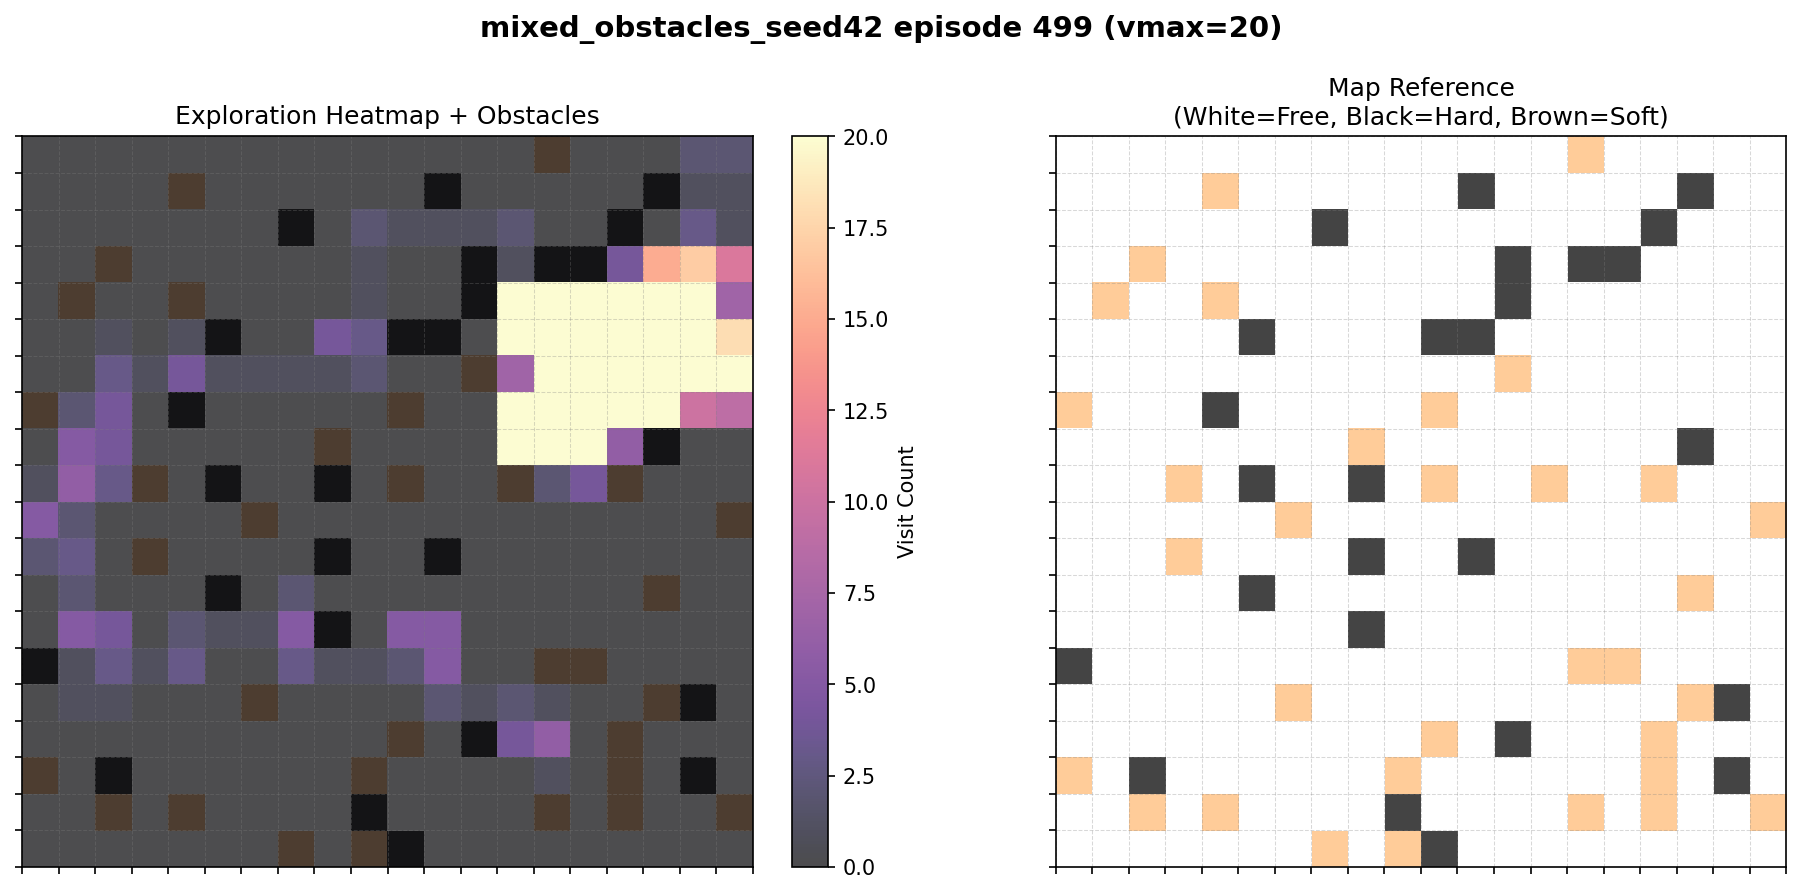

In [6]:
OUTDIR = os.path.join(PROJECT_ROOT, 'analysis_out_notebook')
os.makedirs(OUTDIR, exist_ok=True)
# Re-render heatmap for episode 499 with vmax=20
if os.path.exists(CSV_PATH) and os.path.exists(MAP_PATH):
    df = pd.read_csv(CSV_PATH)
    mp = np.load(MAP_PATH)
    H, W = mp.shape
    env_viz = RoombaSoftPOMDPEnv(width=W, height=H, map_array=mp, random_obstacles=False)
    
    # Filter to episode 499
    ep_df = df[df['episode'] == episode_nr]
    if len(ep_df) > 0:
        print(f'Episode {episode_nr}: {len(ep_df)} transitions')
        
        # Build heatmap from s_x, s_y
        heat = np.zeros((H, W), dtype=float)
        for _, row in ep_df.iterrows():
            try:
                x = int(row['s_x'])
                y = int(row['s_y'])
            except Exception:
                continue
            if 0 <= y < H and 0 <= x < W:
                heat[y, x] += 1
        
        # Render with vmax=20
        out_sub = os.path.dirname(CSV_PATH) if os.path.isfile(CSV_PATH) else CSV_PATH
        heatpath = os.path.join(OUTDIR, f'{MAP_NAME}_ep{episode_nr}_heat_vmax20.png')
        analysis_module.render_heatmap(env_viz, heat, outpath=heatpath, title=f'{MAP_NAME} episode {episode_nr} (vmax=20)', vmax=20)
        display(Image(filename=heatpath))
    else:
        print(f'Episode {episode_nr} not found in CSV')
else:
    print('CSV or map not found')

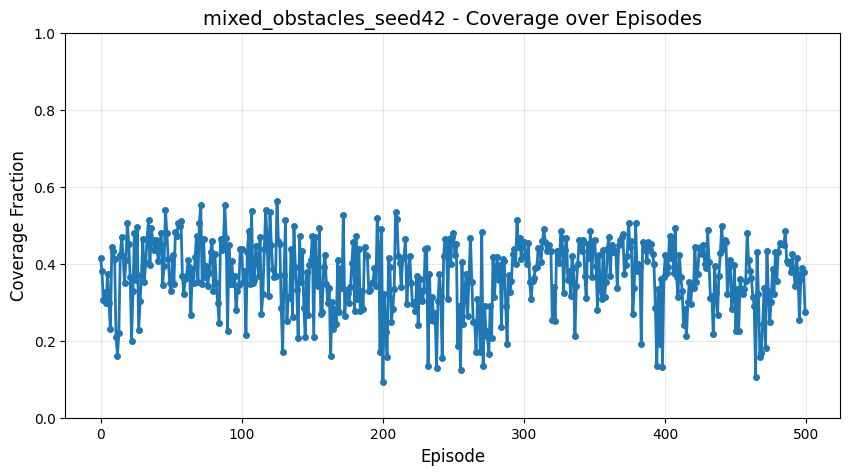

Mean coverage: 0.3701
Final coverage: 0.2754
Coverage plot saved to: c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\analysis_out_notebook\mixed_obstacles_seed42_sarsa_coverage.png


In [7]:
# Calculate and plot coverage across episodes
if 'per_ep' in locals() and len(per_ep) > 0:
    coverages = [m['coverage'] for m in per_ep]
    episodes_nums = list(range(len(per_ep)))
    
    plt.figure(figsize=(10, 5))
    plt.plot(episodes_nums, coverages, marker='o', linestyle='-', linewidth=2, markersize=4)
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Coverage Fraction', fontsize=12)
    plt.title(f'{MAP_NAME} - Coverage over Episodes', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.0)
    
    # Save and display
    coverage_plot_path = os.path.join(OUTDIR, f'{MAP_NAME}_{method}_coverage.png')
    plt.savefig(coverage_plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'Mean coverage: {np.mean(coverages):.4f}')
    print(f'Final coverage: {coverages[-1]:.4f}')
    print(f'Coverage plot saved to: {coverage_plot_path}')
else:
    print('No per-episode data available. Run the analysis cell first.')

Episode with highest coverage: 125 (coverage=0.5642)


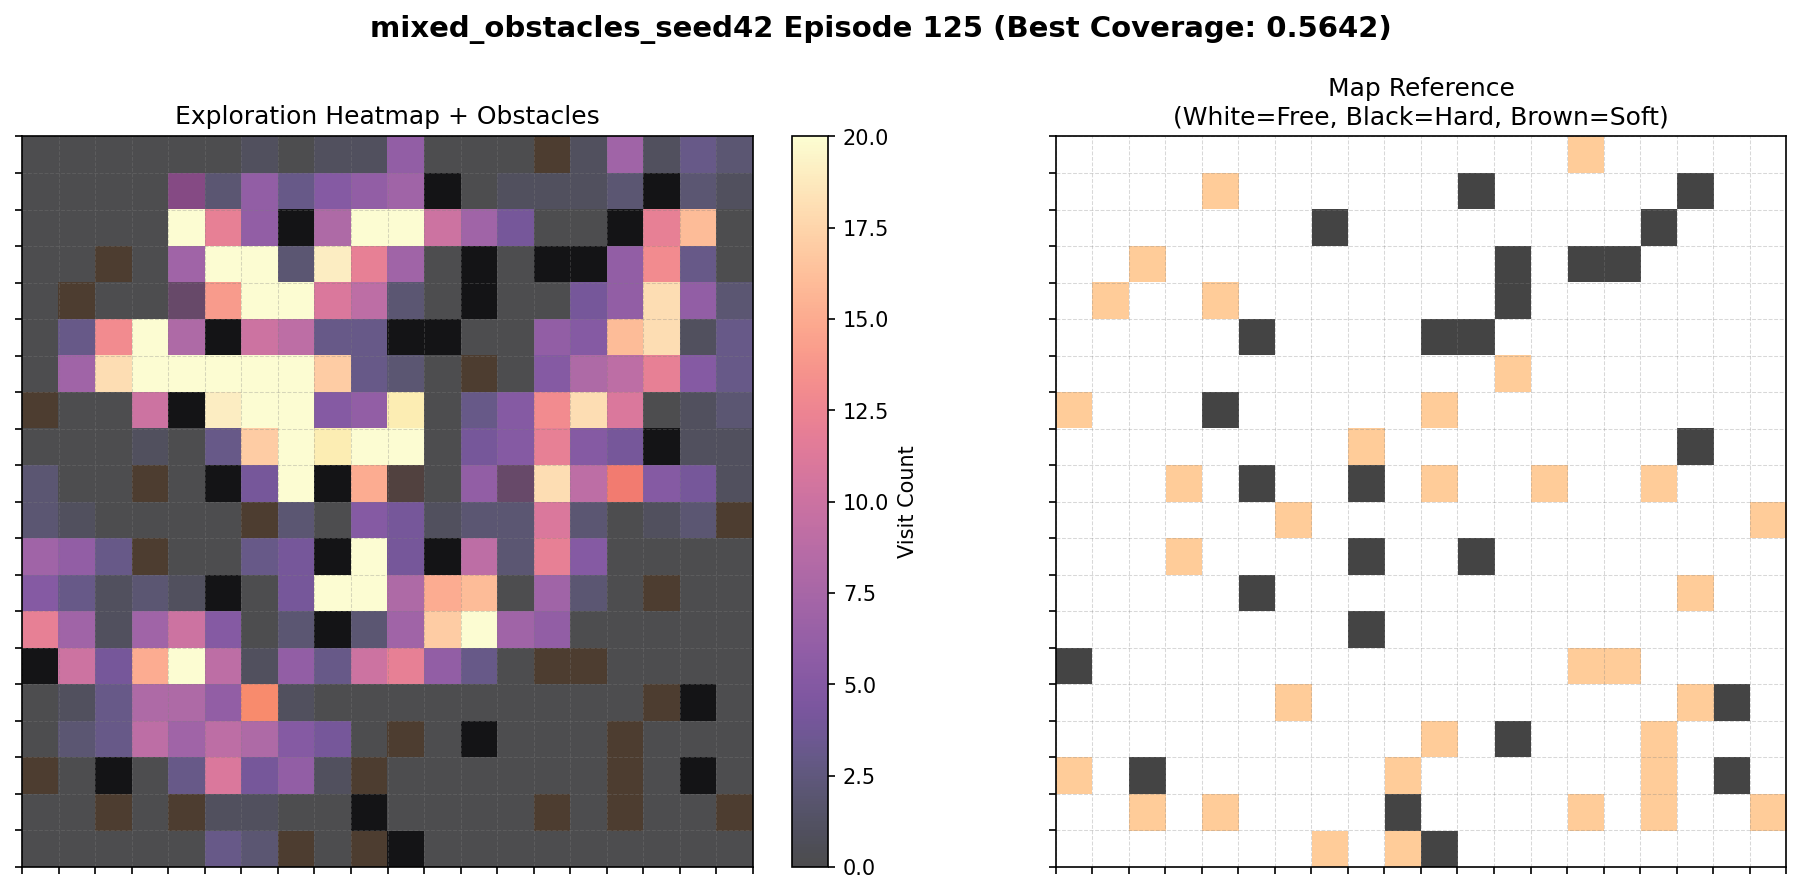

In [8]:
# Find and plot heatmap for episode with highest coverage
if 'per_ep' in locals() and len(per_ep) > 0:
    coverages = [m['coverage'] for m in per_ep]
    best_ep_idx = np.argmax(coverages)
    best_coverage = coverages[best_ep_idx]
    
    print(f'Episode with highest coverage: {best_ep_idx} (coverage={best_coverage:.4f})')
    
    # Get heatmap from best episode
    best_heat = per_ep[best_ep_idx]['heatmap']
    
    # Render with vmax=20
    heatpath_best = os.path.join(OUTDIR, f'{MAP_NAME}_{method}_ep{best_ep_idx}_best_coverage.png')
    analysis_module.render_heatmap(env, best_heat, outpath=heatpath_best, title=f'{MAP_NAME} Episode {best_ep_idx} (Best Coverage: {best_coverage:.4f})', vmax=20)
    display(Image(filename=heatpath_best))
else:
    print('No per-episode data available. Run the analysis cell first.')